In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hierarchical.Hierarchical_Class import prior_vac, Ddc, DDdc
from hierarchical.utility import dc
from scipy.integrate import nquad

startup


In [5]:
#supporting functions

def DM_prior_vac(M, z, K, alpha, beta, H0, Omega_m0, Omega_Lambda0, Mstar):
    C = K * ((1/Mstar)**alpha) * 4 * np.pi
    
    return C * alpha * (M ** (alpha - 1)) * ((1 + z) ** beta) * (dc(z, H0, Omega_m0, Omega_Lambda0) ** 2)

def DlnM_prior_vac(lnM, z, K, alpha, beta, H0, Omega_m0, Omega_Lambda0, Mstar):
    M = np.exp(lnM)
    return DM_prior_vac(M, z, K, alpha, beta, H0, Omega_m0, Omega_Lambda0, Mstar) * M

def Dz_prior_vac(lnM, z, K, alpha, beta, H0, Omega_m0, Omega_Lambda0, Mstar):
    M = np.exp(lnM)
    C = K * ((1/Mstar)**alpha) * 4 * np.pi

    return C * beta * (M ** alpha) * ((1 + z) ** (beta - 1)) * (dc(z, H0, Omega_m0, Omega_Lambda0) ** 2) + 2 * C * (M ** alpha) * ((1 + z)**beta) * dc(z, H0, Omega_m0, Omega_Lambda0) * Ddc(z,H0,Omega_m0,Omega_Lambda0)

def DDlnM_prior_vac(lnM, z, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar):
    M = np.exp(lnM)
    C = K*(1/Mstar)**alpha*4*np.pi
    
    return (C*alpha*(alpha-1)*M**(alpha-2)*(1+z)**beta*dc(z,H0,Omega_m0,Omega_Lambda0)**2)*M**2 + DM_prior_vac(M, z, K, alpha, beta, H0, Omega_m0, Omega_Lambda0, Mstar)*M

def DDz_prior_vac(lnM, z, K, alpha, beta,H0,Omega_m0,Omega_Lambda0, Mstar):
    M = np.exp(lnM)
    C = K*(1/Mstar)**alpha*4*np.pi

    """
    Computes the expression given in Mathematica syntax:
    
    (-1 + beta) * beta * C * M^alpha * (1 + z)^(-2 + beta) * dc[z]^2 
    + 4 * beta * C * M^alpha * (1 + z)^(-1 + beta) * dc[z] * Derivative[1][dc][z] 
    + 2 * C * M^alpha * (1 + z)^beta * Derivative[1][dc][z]^2 
    + 2 * C * M^alpha * (1 + z)^beta * dc[z] * (dc''[z])
    
    Parameters:
        beta, C, M, alpha, z : float
            Constants and variable in the expression
        dc : float
            dc[z] (function value at z)
        Ddc : float
            Derivative of dc with respect to z (dc'[z])
        DDdc : float
            Second derivative of dc with respect to z (dc''[z])
    """

    term1 = (-1 + beta) * beta * C * M ** alpha * (1 + z) ** (-2 + beta) * dc(z,H0,Omega_m0,Omega_Lambda0)** 2
    term2 = 4 * beta * C * M ** alpha * (1 + z) ** (-1 + beta) * dc(z,H0,Omega_m0,Omega_Lambda0)* Ddc(z,H0,Omega_m0,Omega_Lambda0)
    term3 = 2 * C * M ** alpha * (1 + z) ** beta * Ddc(z,H0,Omega_m0,Omega_Lambda0) ** 2
    term4 = 2 * C * M ** alpha * (1 + z) ** beta * dc(z,H0,Omega_m0,Omega_Lambda0) * DDdc(z,H0,Omega_m0,Omega_Lambda0)
    
    return term1 + term2 + term3 + term4

def DlnMDz_prior_vac(lnM, z, K, alpha, beta,H0,Omega_m0,Omega_Lambda0, Mstar):
    M = np.exp(lnM)
    C = K*(1/Mstar)**alpha*4*np.pi

    """
    Computes the expression:
    
    alpha * beta * C * M^(-1 + alpha) * (1 + z)^(-1 + beta) * dc[z]^2 
    + 2 * alpha * C * M^(-1 + alpha) * (1 + z)^beta * dc[z] * Derivative[1][dc][z]
    
    Parameters:
        alpha, beta, C, M, z : float
            Constants and variable in the expression
        dc : float
            dc[z] (function value at z)
        Ddc : float
            Derivative of dc with respect to z (dc'[z])
    """
    term1 = alpha * beta * C * M ** (-1 + alpha) * (1 + z) ** (-1 + beta) * dc(z,H0,Omega_m0,Omega_Lambda0) ** 2
    term2 = 2 * alpha * C * M ** (-1 + alpha) * (1 + z) ** beta * dc(z,H0,Omega_m0,Omega_Lambda0) * Ddc(z,H0,Omega_m0,Omega_Lambda0)
    
    return M * (term1 + term2) #multiplied by M for chain rule since this is actually d/dlnMdz

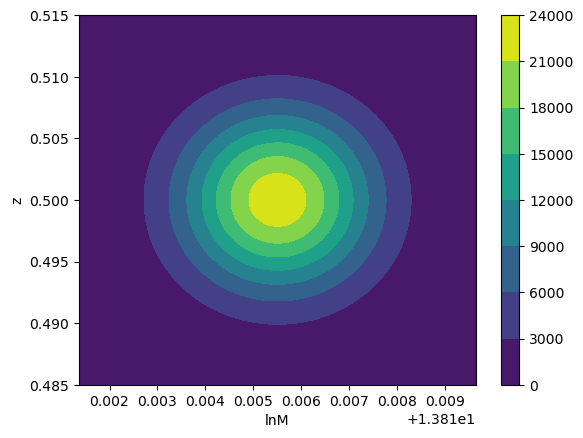

In [10]:
def prior_taylor(lnM, z, theta_hat, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar):
    
    lnMhat, zhat = theta_hat
    
    term_0 = prior_vac(lnMhat, zhat, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar)
    
    term_1 = ((lnM - lnMhat) * DlnM_prior_vac(lnMhat, zhat, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar) + 
              (z - zhat) * Dz_prior_vac(lnMhat, zhat, K, alpha, beta, H0, Omega_m0, Omega_Lambda0, Mstar))
    
    term_2 = (((lnM - lnMhat)**2/2) * DDlnM_prior_vac(lnMhat, zhat, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar) + 
              ((z - zhat)**2/2) * DDz_prior_vac(lnMhat, zhat, K, alpha, beta,H0,Omega_m0,Omega_Lambda0, Mstar) + 
              (lnM - lnMhat) * (z - zhat) * DlnMDz_prior_vac(lnMhat, zhat, K, alpha, beta,H0,Omega_m0,Omega_Lambda0, Mstar))
    
    return (
        term_0 
        + term_1 
        + term_2
    )

def likelihood(lnM, z, theta_hat, Fisher):
    
    theta = np.array((lnM,z))
    
    assert len(theta) == len(theta_hat)
    
    return (np.linalg.det(Fisher)**(1/2))/((2 * np.pi)**(len(Fisher)/2)) * np.exp(-0.5 * np.array(theta - theta_hat)@Fisher@np.array(theta - theta_hat))

lnMhat = np.log(1e6)
zhat = 0.5
theta_hat = np.array((lnMhat, zhat))

K = 5e-3
Mstar = 3e6
alpha = 0.02
beta = 0.02

Omega_m0 = 0.30
Omega_Lambda0 = 0.70
H0 = 70e3

std_lnM = 1e-4*lnMhat
std_z = 1e-2*zhat
covariance = np.array([[(std_lnM)**2,0.0],[0.0, (std_z)**2]])
Fisher = np.linalg.inv(covariance)

lnMrange = np.linspace(lnMhat - 3*std_lnM, lnMhat + 3*std_lnM, 100)
zrange = np.linspace(zhat - 3*std_z, zhat + 3*std_z, 100)

lnMgrid, zgrid = np.meshgrid(lnMrange, zrange)

likelihood_grid = []
for lnM in lnMgrid[0]:
    likelihood_givenlnM = []
    for z in zgrid[:,0]:
        likelihood_givenlnM.append(likelihood(lnM,z,theta_hat,Fisher))
    likelihood_grid.append(np.array(likelihood_givenlnM))
    
likelihood_grid = np.array(likelihood_grid)
plt.contourf(lnMgrid, zgrid, likelihood_grid)
plt.colorbar()
plt.xlabel("lnM")
plt.ylabel("z")
plt.show()

In [11]:
def integrand_exact(lnM, z, theta_hat, Fisher, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar):
    return prior_vac(lnM, z, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar) * likelihood(lnM, z, theta_hat, Fisher)

def integrand_taylor(lnM, z, theta_hat, Fisher, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar):
    return prior_taylor(lnM, z, theta_hat, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar) * likelihood(lnM, z, theta_hat, Fisher)

results_exact, error_exact = nquad(integrand_exact, 
                                   ranges=[[lnMrange[0],lnMrange[1]],[zrange[0],zrange[1]]],
                                   args=(theta_hat, Fisher, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar))

results_taylor, error_taylor = nquad(integrand_taylor, 
                                    ranges=[[lnMrange[0],lnMrange[1]],[zrange[0],zrange[1]]],
                                    args=(theta_hat, Fisher, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar))

(results_exact, error_exact), (results_taylor, error_taylor), results_exact/results_taylor

((0.018171812345309218, 7.273557986939437e-13),
 (0.018166524326794928, 7.271484456352583e-13),
 1.000291085868665)

210110280026.76093 210110280026.761


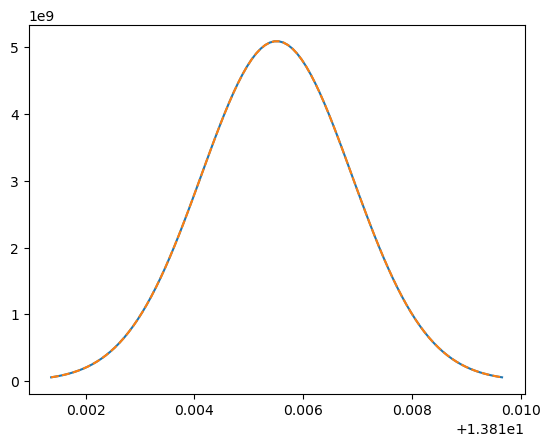

In [12]:
integrand_ex = []
integrand_tay = []
for lnM in lnMrange:
    integrand_ex.append(integrand_exact(lnM, zhat, theta_hat, Fisher, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar))
    integrand_tay.append(integrand_taylor(lnM, zhat, theta_hat, Fisher, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar))
    
plt.plot(lnMrange, integrand_ex)
plt.plot(lnMrange, integrand_tay,linestyle='--')
#plt.yscale('log')
#plt.xscale('log')

print(sum(integrand_ex),sum(integrand_tay))

1.0000299719248797


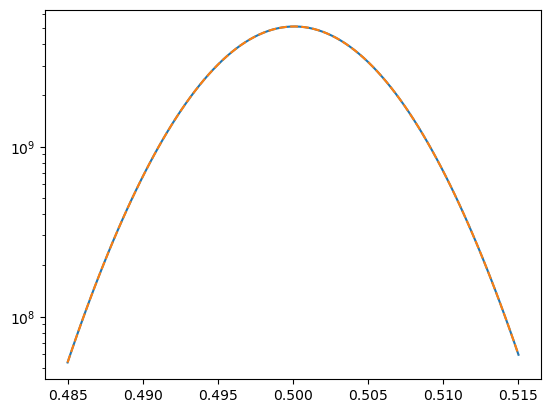

In [13]:
integrand_ex = []
integrand_tay = []
for z in zrange:
    integrand_ex.append(integrand_exact(lnMhat, z, theta_hat, Fisher, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar))
    integrand_tay.append(integrand_taylor(lnMhat, z, theta_hat, Fisher, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar))
    
plt.plot(zrange, integrand_ex)
plt.plot(zrange, integrand_tay,linestyle='--')
plt.yscale('log')
#plt.xscale('log')

print(sum(integrand_ex)/sum(integrand_tay))